In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [4]:
words = open('/drive/My Drive/Dev/makemore/names.txt','r').read().splitlines()

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
# print(itos)

In [31]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 4]) torch.Size([182580])
torch.Size([22767, 4]) torch.Size([22767])
torch.Size([22799, 4]) torch.Size([22799])


In [24]:
g = torch.Generator().manual_seed(1234567890) # for reproducibility
C = torch.randn((27, 10), generator=g) # 27 possible inputs to 10 neurons
W1 = torch.randn((30, 200), generator=g) # 10 neurons into 3 inputs = 30 neurons to 200 (middle layer)
b1 = torch.randn(200, generator=g) # bias for middle layer
W2 = torch.randn((200, 27), generator=g) # 200 to 27 possible outputs
b2 = torch.randn(27, generator=g) # bias for 27 possible outputs
parameters = [C, W1, b1, W2, b2]

In [12]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [25]:
for p in parameters:
  p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [26]:
for i in range(100000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (512,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 70000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

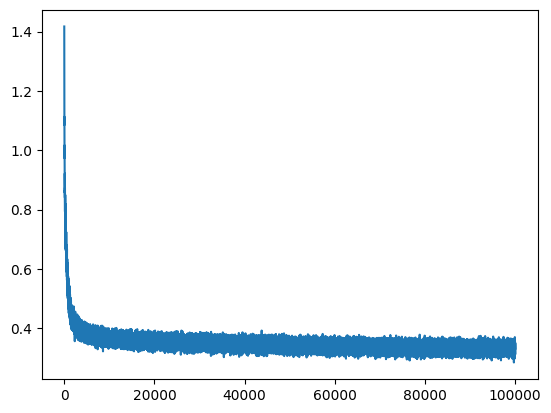

In [27]:
plt.plot(stepi, lossi)

In [28]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1577, grad_fn=<NllLossBackward0>)

In [29]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1933, grad_fn=<NllLossBackward0>)

In [30]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mona.
kayah.
see.
med.
ryal.
ren.
ruchadraen.
adeled.
elin.
shi.
jen.
edelieananar.
kayzion.
kalin.
shubvigsaimiel.
kin.
reneliquetzacon.
brey.
dariyah.
fael.
